# Custom Training with Tensorflow 2
In this notebook we learn how to compute gradients with tensorflow 2 and how to use them for 
custom model training.

In [228]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, metrics, losses
from matplotlib import pyplot as plt

## 1. Computing gradients
- to compute gradients you need the tf.GradientTape()context

**First Derivative**

In [9]:
x = tf.constant(3.)

In [15]:
with tf.GradientTape() as tpe:
    tpe.watch(x)
    
    # function needs to be defined in the context
    y = tf.square(x)
    
dy_dx = tpe.gradient(y,x)  # dy/dx|3 = 2x|3 = 6
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


**Second Derivative**

In [16]:
with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
        gg.watch(x)
        # function needs to be defined in the context
        y = tf.square(x)
        dy_dx = gg.gradient(y,x)  # dy/dx|3 = 2x|3 = 6
    dy_dx_2 = g.gradient(dy_dx, x) # d(2x)/dy = 2
print(dy_dx)
print(dy_dx_2)

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


**Gradient Descent**
Finding minimum of quadratic loss function using gradient descent. First, we update using the simple gradient descent rule $x_n = x - \alpha \frac{dy}{dx}$. Afterwards, we use an optimzer keras provides.

In [18]:
def loss(x):
    return (x-3)**2

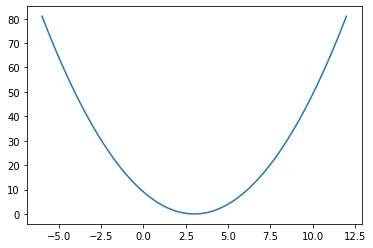

In [23]:
x = np.linspace(start=-6, stop=12, num=100)
plt.plot(x, loss(x))

In [66]:
x_start = tf.Variable(10.0)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)
learning_rate = 0.1
epochs = 100
for epoch in range(epochs):
    with tf.GradientTape() as g:
        g.watch(x_start)
        current_loss = loss(x_start)
        dloss_dx = g.gradient(current_loss, x_start)
    x_start.assign_add(-learning_rate*dloss_dx)
    if epoch % 20 == 0:
        print("Results during epoch: ", epoch)
        print("next x: ", x_start.numpy())
        print("current loss: ", current_loss.numpy())
        print("dloss_dx: ", dloss_dx.numpy())
        print("")

Results during epoch:  0
next x:  8.6
current loss:  49.0
dloss_dx:  14.0

Results during epoch:  20
next x:  3.0645635
current loss:  0.006513208
dloss_dx:  0.1614089

Results during epoch:  40
next x:  3.0007443
current loss:  8.654754e-07
dloss_dx:  0.0018606186

Results during epoch:  60
next x:  3.0000086
current loss:  1.1510792e-10
dloss_dx:  2.1457672e-05

Results during epoch:  80
next x:  3.0000005
current loss:  2.2737368e-13
dloss_dx:  9.536743e-07



In [67]:
x_start = tf.Variable(10.0)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)
learning_rate = 0.1
epochs = 100
for epoch in range(epochs):
    with tf.GradientTape() as g:
        g.watch(x_start)
        current_loss = loss(x_start)
        dloss_dx = g.gradient(current_loss, x_start)
    optimizer.apply_gradients(zip([dloss_dx],[x_start]))
    if epoch % 20 == 0:
        print("Results during epoch: ", epoch)
        print("next x: ", x_start.numpy())
        print("current loss: ", current_loss.numpy())
        print("dloss_dx: ", dloss_dx.numpy())
        print("")

Results during epoch:  0
next x:  9.683772
current loss:  49.0
dloss_dx:  14.0

Results during epoch:  20
next x:  7.259191
current loss:  18.925993
dloss_dx:  8.700803

Results during epoch:  40
next x:  5.589483
current loss:  7.1140885
dloss_dx:  5.33445

Results during epoch:  60
next x:  4.180467
current loss:  1.5444623
dloss_dx:  2.485528

Results during epoch:  80
next x:  3.2355545
current loss:  0.07062252
dloss_dx:  0.53149796



## 2. Linear Regresion

In [74]:
def my_function(x_arr, w0=2.3, w1=-3.7, noise=1.5):
    y = w1 * x_arr + w0 + np.random.normal(scale=noise, size=len(x_arr))
    return y

In [75]:
x = np.linspace(start=-5, stop=5, num=100)
y = my_function(x)

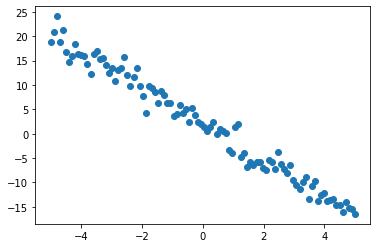

In [78]:
plt.plot(x,y, linestyle="None", marker="o")

In [127]:
x_data = tf.data.Dataset.from_tensor_slices(np.expand_dims(x,-1))
y_data = tf.data.Dataset.from_tensor_slices(y)
regression_data = tf.data.Dataset.zip((x_data,y_data))

In [128]:
input_dim = x_data.element_spec.shape[0]

### a) keras fit method

In [143]:
regressor = tf.keras.Sequential()
regressor.add(layers.Dense(1, input_shape=(1,))) # features, examples

In [144]:
regressor.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [145]:
regressor.compile(loss=losses.mean_squared_error)

In [151]:
regressor.fit(regression_data, epochs=100, verbose=0)

In [157]:
print(regressor.weights[0].numpy())
print(regressor.weights[1].numpy())

[[-3.715647]]
[2.0540555]


In [164]:
y_pred = regressor.predict(x_data)
y_pred[0]

array([20.632292], dtype=float32)

### b) custom training

In [304]:
class CustomTraining():
    
    def __init__(self, model, batch_size=32, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1), loss=losses.MeanSquaredError()):
        self.model = model
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.loss = loss
    
    def train_epoch(self, X,y):
        loss_total = 0
        batches = 0
        for i, (X_batch, y_batch) in enumerate(zip(X,y)):
            with tf.GradientTape() as g:
                g.watch(self.model.weights)
                y_pred = self.model(X_batch)
                loss_epoch = self.loss(y_batch, y_pred)
                grads = g.gradient(loss_epoch, self.model.weights)
            loss_total = loss_total + loss_epoch.numpy()
            self.optimizer.apply_gradients(zip(grads,self.model.weights))
            batches = batches + i
        return loss_total / batches
        
    def fit(self, X, y, epochs=1, verbose=True):
        X_ = X.batch(self.batch_size)
        y_ = y.batch(self.batch_size)
        for epoch in range(epochs):
            loss = self.train_epoch(X_,y_)
            if verbose:
                if epoch % 10 == 0:
                    print("epoch: ", epoch)
                    print("loss: ", loss)
                    print("model: ", self.model.weights)
        
    

In [305]:
regressor = tf.keras.Sequential()
regressor.add(layers.Dense(1, input_shape=(1,))) # features, examples

In [306]:
custom = CustomTraining(model=regressor)

In [307]:
custom.train_epoch(x_data.batch(32), y_data.batch(32))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



192.41701380411783

In [308]:
custom.fit(x_data, y_data, epochs=100, verbose=True)

epoch:  0
loss:  147.12256304423013
model:  [<tf.Variable 'dense_20/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.50162536]], dtype=float32)>, <tf.Variable 'dense_20/bias:0' shape=(1,) dtype=float32, numpy=array([-0.12403852], dtype=float32)>]
epoch:  10
loss:  18.582685311635334
model:  [<tf.Variable 'dense_20/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.2838416]], dtype=float32)>, <tf.Variable 'dense_20/bias:0' shape=(1,) dtype=float32, numpy=array([-0.2991233], dtype=float32)>]
epoch:  20
loss:  2.422836869955063
model:  [<tf.Variable 'dense_20/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-3.4732163]], dtype=float32)>, <tf.Variable 'dense_20/bias:0' shape=(1,) dtype=float32, numpy=array([1.1818415], dtype=float32)>]
epoch:  30
loss:  1.6612948973973591
model:  [<tf.Variable 'dense_20/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-3.5703938]], dtype=float32)>, <tf.Variable 'dense_20/bias:0' shape=(1,) dtype=float32, numpy=array([2.2343714], dtype=float3

In [295]:
custom.model.weights

[<tf.Variable 'dense_17/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-3.5702415]], dtype=float32)>,
 <tf.Variable 'dense_17/bias:0' shape=(1,) dtype=float32, numpy=array([2.251594], dtype=float32)>]

In [197]:
X,y = make_classification(n_samples=100, n_features=2, n_redundant=0, random_state=42)

In [516]:
X, X_test, y, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [517]:
X_data = tf.data.Dataset.from_tensor_slices(X).batch(16)
y_data = tf.data.Dataset.from_tensor_slices(y).batch(16)
data = tf.data.Dataset.zip((X_data, y_data))

### built-in keras model

In [518]:
model =tf.keras.Sequential()
model.add(layers.Dense(1, input_shape=(2,)))
model.add(layers.Activation(tf.nn.sigmoid))

In [519]:
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 1)                 3         
_________________________________________________________________
activation_73 (Activation)   (None, 1)                 0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [520]:
model.input

<tf.Tensor 'dense_80_input:0' shape=(None, 2) dtype=float32>

In [521]:
model.compile(loss=losses.binary_crossentropy, metrics=["accuracy"])

In [524]:
model.fit(X,y, epochs=10, batch_size=16)

Train on 80 samples
Epoch 1/10
80/80 [==============================] - 0s 298us/sample - loss: 1.0905 - accuracy: 0.4000
Epoch 2/10
80/80 [==============================] - 0s 174us/sample - loss: 1.0857 - accuracy: 0.4000
Epoch 3/10
80/80 [==============================] - 0s 152us/sample - loss: 1.0809 - accuracy: 0.4000
Epoch 4/10
80/80 [==============================] - 0s 230us/sample - loss: 1.0762 - accuracy: 0.4000
Epoch 5/10
80/80 [==============================] - 0s 270us/sample - loss: 1.0713 - accuracy: 0.4000
Epoch 6/10
80/80 [==============================] - 0s 268us/sample - loss: 1.0666 - accuracy: 0.4125
Epoch 7/10
80/80 [==============================] - 0s 192us/sample - loss: 1.0617 - accuracy: 0.4125
Epoch 8/10
80/80 [==============================] - 0s 397us/sample - loss: 1.0570 - accuracy: 0.4250
Epoch 9/10
80/80 [==============================] - 0s 287us/sample - loss: 1.0523 - accuracy: 0.4250
Epoch 10/10
80/80 [==============================] - 0s 245us/

In [525]:
model.predict(X)

array([[0.8800186 ],
       [0.549698  ],
       [0.785006  ],
       [0.1833115 ],
       [0.2452526 ],
       [0.8910201 ],
       [0.31538123],
       [0.6776275 ],
       [0.87074286],
       [0.31687728],
       [0.3627581 ],
       [0.8689618 ],
       [0.15098341],
       [0.15089563],
       [0.6378209 ],
       [0.24943331],
       [0.8973662 ],
       [0.61711556],
       [0.29531568],
       [0.71479034],
       [0.75450593],
       [0.14664929],
       [0.3245311 ],
       [0.42136616],
       [0.50786066],
       [0.6530947 ],
       [0.37605837],
       [0.4801928 ],
       [0.3080136 ],
       [0.26759043],
       [0.71887094],
       [0.6811843 ],
       [0.7242301 ],
       [0.7754773 ],
       [0.8479359 ],
       [0.86165786],
       [0.92784965],
       [0.38679603],
       [0.5613064 ],
       [0.77490234],
       [0.16259794],
       [0.51793253],
       [0.28424367],
       [0.21209168],
       [0.49498746],
       [0.6931041 ],
       [0.7376695 ],
       [0.164

In [526]:
optimizer = tf.keras.optimizers.RMSprop()

In [538]:
model =tf.keras.Sequential()
model.add(layers.Dense(1, input_shape=(2,)))
model.add(layers.Activation(tf.nn.relu))
model.add(layers.Dense(12))
model.add(layers.Activation(tf.nn.relu))
model.add(layers.Dense(1))
model.add(layers.Activation(tf.nn.sigmoid))

In [551]:
for epoch in range(100):
    #print("epoch", epoch)
    loss_sum = 0
    N = 0
    for x_batch, y_batch in data:
        
        with tf.GradientTape() as tpe:
            tpe.watch(model.trainable_variables)
            y_pred = model(x_batch, training=True)
            #print(model.trainable_weights)
            loss_sum = tf.reduce_mean(losses.binary_crossentropy(np.expand_dims(y_batch,-1), y_pred, from_logits=True))
            #n = x_batch.shape[0]
            #loss = loss_sum/n
            #N = n + N
            grads = tpe.gradient(loss_sum, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 10 == 0:
        print(loss_sum.numpy())
        #print(grads)

0.56971747
0.56213033
0.55508447
0.548448
0.54253495
0.53719985
0.5320817
0.52750957
0.5237171
0.52085793


In [552]:
list(y_data)

[<tf.Tensor: shape=(16,), dtype=int64, numpy=array([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0])>,
 <tf.Tensor: shape=(16,), dtype=int64, numpy=array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])>,
 <tf.Tensor: shape=(16,), dtype=int64, numpy=array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])>,
 <tf.Tensor: shape=(16,), dtype=int64, numpy=array([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1])>,
 <tf.Tensor: shape=(16,), dtype=int64, numpy=array([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1])>]

In [553]:
res = model.predict(X_test)

In [554]:
preds = np.where(res[:,0]>0.5, 1, 0)

In [555]:
y_test

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0])

In [556]:
preds

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0])